In [25]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
import pandas as pd
import random
import matplotlib.image as mpimg
from PIL import Image
 
from tensorflow.keras import Sequential 
from tensorflow.keras import models
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow .keras.preprocessing.image import ImageDataGenerator


In [2]:
# Directory to dataset 
data_dir = '/Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data'


In [17]:
import os
import cv2

def load_data(directory):
    images = []
    labels = []
    
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)

        # Check if class_name is a directory
        if not os.path.isdir(class_path):
            print(f"Skipping non-directory: {class_path}")
            continue
        
        images_path = os.path.join(class_path, 'images')
        labels_path = os.path.join(class_path, 'labels')

        # Check if images_path and labels_path are valid directories
        if not os.path.isdir(images_path) or not os.path.isdir(labels_path):
            print(f"Invalid directory structure in {class_path}. Skipping.")
            continue
        
        # Get category label from class_name (e.g., 'Glioma', 'No Tumor', etc.)
        category_label = class_name  # You can modify this if your labels are structured differently
        
        for image in os.listdir(images_path):
            # Skip hidden files like .DS_Store
            if image.startswith('.'):
                continue

            img_path = os.path.join(images_path, image)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image {image}, skipping.")
                continue
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            
            # Corresponding label file
            label_file = image.rsplit('.', 1)[0] + '.txt'  # Handle different extensions
            label_file_path = os.path.join(labels_path, label_file)
            
            if os.path.exists(label_file_path):
                with open(label_file_path, 'r') as file:
                    label_data = file.readline().strip()
                    
                    if label_data:  # Check if label data is not empty
                        images.append(img)
                        labels.append(category_label)  # Append the category label instead of raw label data
                    else:
                        print(f"Label file {label_file_path} is empty, skipping this image.")
            else:
                print(f"Label file {label_file_path} not found, skipping this image.")
    
    return images, labels

# Paths to data directories
train_path = '/Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Train'
val_path = '/Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Val'

# Load training and validation data
train_images, train_labels = load_data(train_path)
val_images, val_labels = load_data(val_path)

# Print the number of images loaded and the categories
print(f'Loaded {len(train_images)} images from {len(set(train_labels))} categories.')
print('Categories:', set(train_labels))


print(f'Loaded {len(val_images)} images from {len(set(val_labels))} categories.')
print('Categories:', set(val_labels))

Skipping non-directory: /Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Train/.DS_Store
Skipping non-directory: /Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Val/.DS_Store
Label file /Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Val/No Tumor/labels/image(55).txt not found, skipping this image.
Label file /Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Val/No Tumor/labels/image(61).txt not found, skipping this image.
Label file /Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Val/Glioma/labels/gg (342).txt is empty, skipping this image.
Loaded 3670 images from 4 categories.
Categories: {'Glioma', 'Pituitary', 'Meningioma', 'No Tumor'}
Loaded 509 images from 4 categories.
Categories: {'Glioma', 'Pituitary', 'Meningioma', 'No Tumor'}


#### 3670 traning images and 509 validation images were uploaded between 4 categories: Meningioma, Pituitary, Glimoa, No Tumor

In [6]:
# Identify if corrupted images are in data set with this function
def verify_images(folder):
    for file in os.listdir(folder):
        try:
            img = Image.open(os.path.join(folder, file))
            img.verify()  # Check if the image is corrupted
        except (IOError, SyntaxError) as e:
            print(f"Corrupted image: {file}")


#### The dataset does NOT contain corrupted images

In [19]:
# How many of each class for Training Data
# Training labels using numpy
train_labels_np = np.array(train_labels)

# Get unique classes and their counts
unique_classes, class_counts = np.unique(train_labels_np, return_counts=True)

# Print class counts
for class_name, count in zip(unique_classes, class_counts):
    print(f'Class: {class_name}, {count}')
    

print(f'Number of images in Training data: 3670')

Class: Glioma, 1153
Class: Meningioma, 382
Class: No Tumor, 711
Class: Pituitary, 1424
Number of images in Training data: 3670


In [18]:
# How many of each class for Validation Data
# Training labels using numpy 
val_labels_np = np.array(val_labels)

# Get unique classes and their counts for validation data
unique_val_classes, val_class_counts = np.unique(val_labels_np, return_counts=True)

# Print class counts for validation data
for class_name, count in zip(unique_val_classes, val_class_counts):
    print(f'Class: {class_name},  {count}')
    
print(f'Number of images in Validation data: 509')

Class: Glioma,  135
Class: Meningioma,  140
Class: No Tumor,  98
Class: Pituitary,  136
Number of images in Validation data: 509


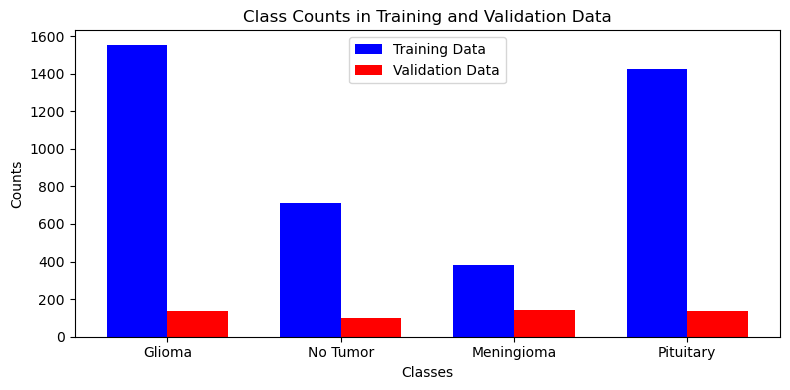

In [20]:
# Visualize class counts

train_class_counts = {'Glioma': 1553, 'No Tumor': 711, 'Meningioma': 382, 'Pituitary': 1424}
val_class_counts = {'Glioma': 135, 'No Tumor': 98, 'Meningioma': 140, 'Pituitary': 136}


# Prepare data for plotting
categories = list(train_class_counts.keys())
train_counts = list(train_class_counts.values())
val_counts = list(val_class_counts.values())

# Bar width and positions
bar_width = 0.35
x = np.arange(len(categories))

# Create the bar plot
plt.figure(figsize=(8, 4))
plt.bar(x - bar_width/2, train_counts, width=bar_width, label='Training Data', color='b')
plt.bar(x + bar_width/2, val_counts, width=bar_width, label='Validation Data', color='r')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts in Training and Validation Data')
plt.xticks(x, categories)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

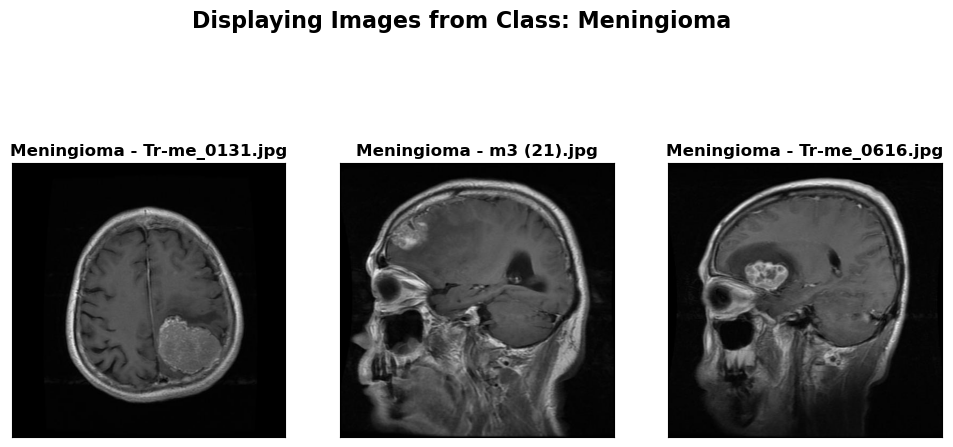

In [52]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

def display_random_images(directory, num_images=3, seed=45):  # Added seed parameter
    random.seed(seed)  # Set the random seed for reproducibility
    
    # Iterate over each class in the given directory
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        
        # Ensure the path is a directory
        if not os.path.isdir(class_path):
            continue  # Skip non-directories
        
        # Assuming images are stored directly in the class directories
        images = os.listdir(class_path)  # Images are in the class directory
        
        # Filter out hidden files (e.g., .DS_Store) and directories
        images = [img for img in images if not img.startswith('.') and not os.path.isdir(os.path.join(class_path, img))]
        
        if len(images) == 0:
            continue  # Skip if there are no images
        
        selected_images = random.sample(images, min(num_images, len(images)))  # Sample images
        
        # Create subplots for displaying images
        fig, axes = plt.subplots(1, len(selected_images), figsize=(12,6))
        fig.suptitle(f"Displaying Images from Class: {class_name}", fontsize=16, fontweight='bold')
        
        for ax, image in zip(axes, selected_images):
            image_path = os.path.join(class_path, image)  # Use class_path to get the image path
            img = mpimg.imread(image_path)  # Read image directly from the class path
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            ax.imshow(img)
            ax.set_title(f"{class_name} - {os.path.basename(image)}", fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
        
        plt.show()  # Show the images

# Paths to training and validation data directories
train_path = '/Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Train'
val_path = '/Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Val'

# Display random images from the training dataset
display_random_images(train_path, num_images=3, seed=45)  # Set the seed here

# Optionally, display random images from the validation dataset as well
display_random_images(val_path, num_images=3, seed=45)  # Use the same seed



In [ ]:
# Function to preprocess the image
def preprocess_image(image):
    # Adjust contrast
    image = augment_with_contrast(image)
    
    # Apply sharpening to the entire image
    image_np = apply_sharpening(image)
    
    # Resize to 224x224
    image_np = cv2.resize(image_np, (224, 224))  
    
    # Normalize the image to [0, 1] range if it is in [0, 255]
    if image_np.max() > 1.0:  # Assuming it was in [0, 255]
        image_np = image_np / 255.0

    # Convert back to Tensor
    return tf.convert_to_tensor(image_np)


#### These three images are could use adjustments such as brightening, sharpening, shifting, and zooming. 

Found 4737 images belonging to 4 classes.
Found 512 images belonging to 4 classes.


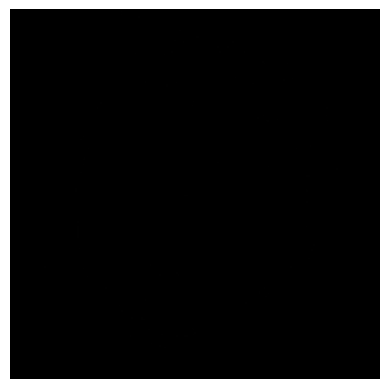

In [134]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Function to adjust contrast
def augment_with_contrast(image):
    contrast_factor = 1.5  # Adjust this value as needed
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image

# Function to apply sharpening filter (without a mask)
def apply_sharpening(image):
    # Convert the Tensor image to a NumPy array
    image_np = image.numpy()
    
    # Define a sharpening filter (Laplacian filter)
    sharpening_filter = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])

    # Resize to 224x224
    image_np = cv2.resize(image_np, (224, 224))  
    
    # Normalize the image to [0, 255] range if it is in [0, 1]
    if image_np.max() <= 1.0:  # Assuming it was in [0, 1]
        image_np = image_np * 255.0

    # Apply the sharpening filter to the entire image
    sharpened_image = cv2.filter2D(image_np.astype(np.uint8), -1, sharpening_filter)
    
    # Clip values to ensure they are in the valid range
    sharpened_image = np.clip(sharpened_image, 0, 255)

    # Convert back to Tensor and normalize to [0, 1]
    return tf.convert_to_tensor(sharpened_image / 255.0)

# Function to preprocess the image
def preprocess_image(image):
    # Adjust contrast
    image = augment_with_contrast(image)
    
    # Apply sharpening to the entire image
    image = apply_sharpening(image)
    
    return image  # No need to resize here; it is done in apply_sharpening

# Define the parameters for the ImageDataGenerator
train_datagen = ImageDataGenerator(
    brightness_range=[0.8, 2],
    rescale=1/255,
    rotation_range=20,
    width_shift_range=0.0,
    height_shift_range=0.0,
    zoom_range=0.0,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_image  
)

val_datagen = ImageDataGenerator()  # No augmentation for validation data

# Define paths to training and validation data
train_image_dir = '/Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Train'  
val_image_dir = '/Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Val' 

# Load and augment training data
train_generator = train_datagen.flow_from_directory(
    train_image_dir,
    target_size=(224, 224),  
    batch_size=100,                     
    class_mode='categorical'                        
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    val_image_dir,
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical'                 
)

# Function to visualize an image
def visualize_image(image):
    plt.imshow(image)  # Use the image directly as a NumPy array
    plt.axis('off')  # Hide axis
    plt.show()

# Example: visualize a batch of images from the train_generator
# Get one batch from the generator
images, labels = next(train_generator)

# Visualize the first image in the batch
visualize_image(images[0])



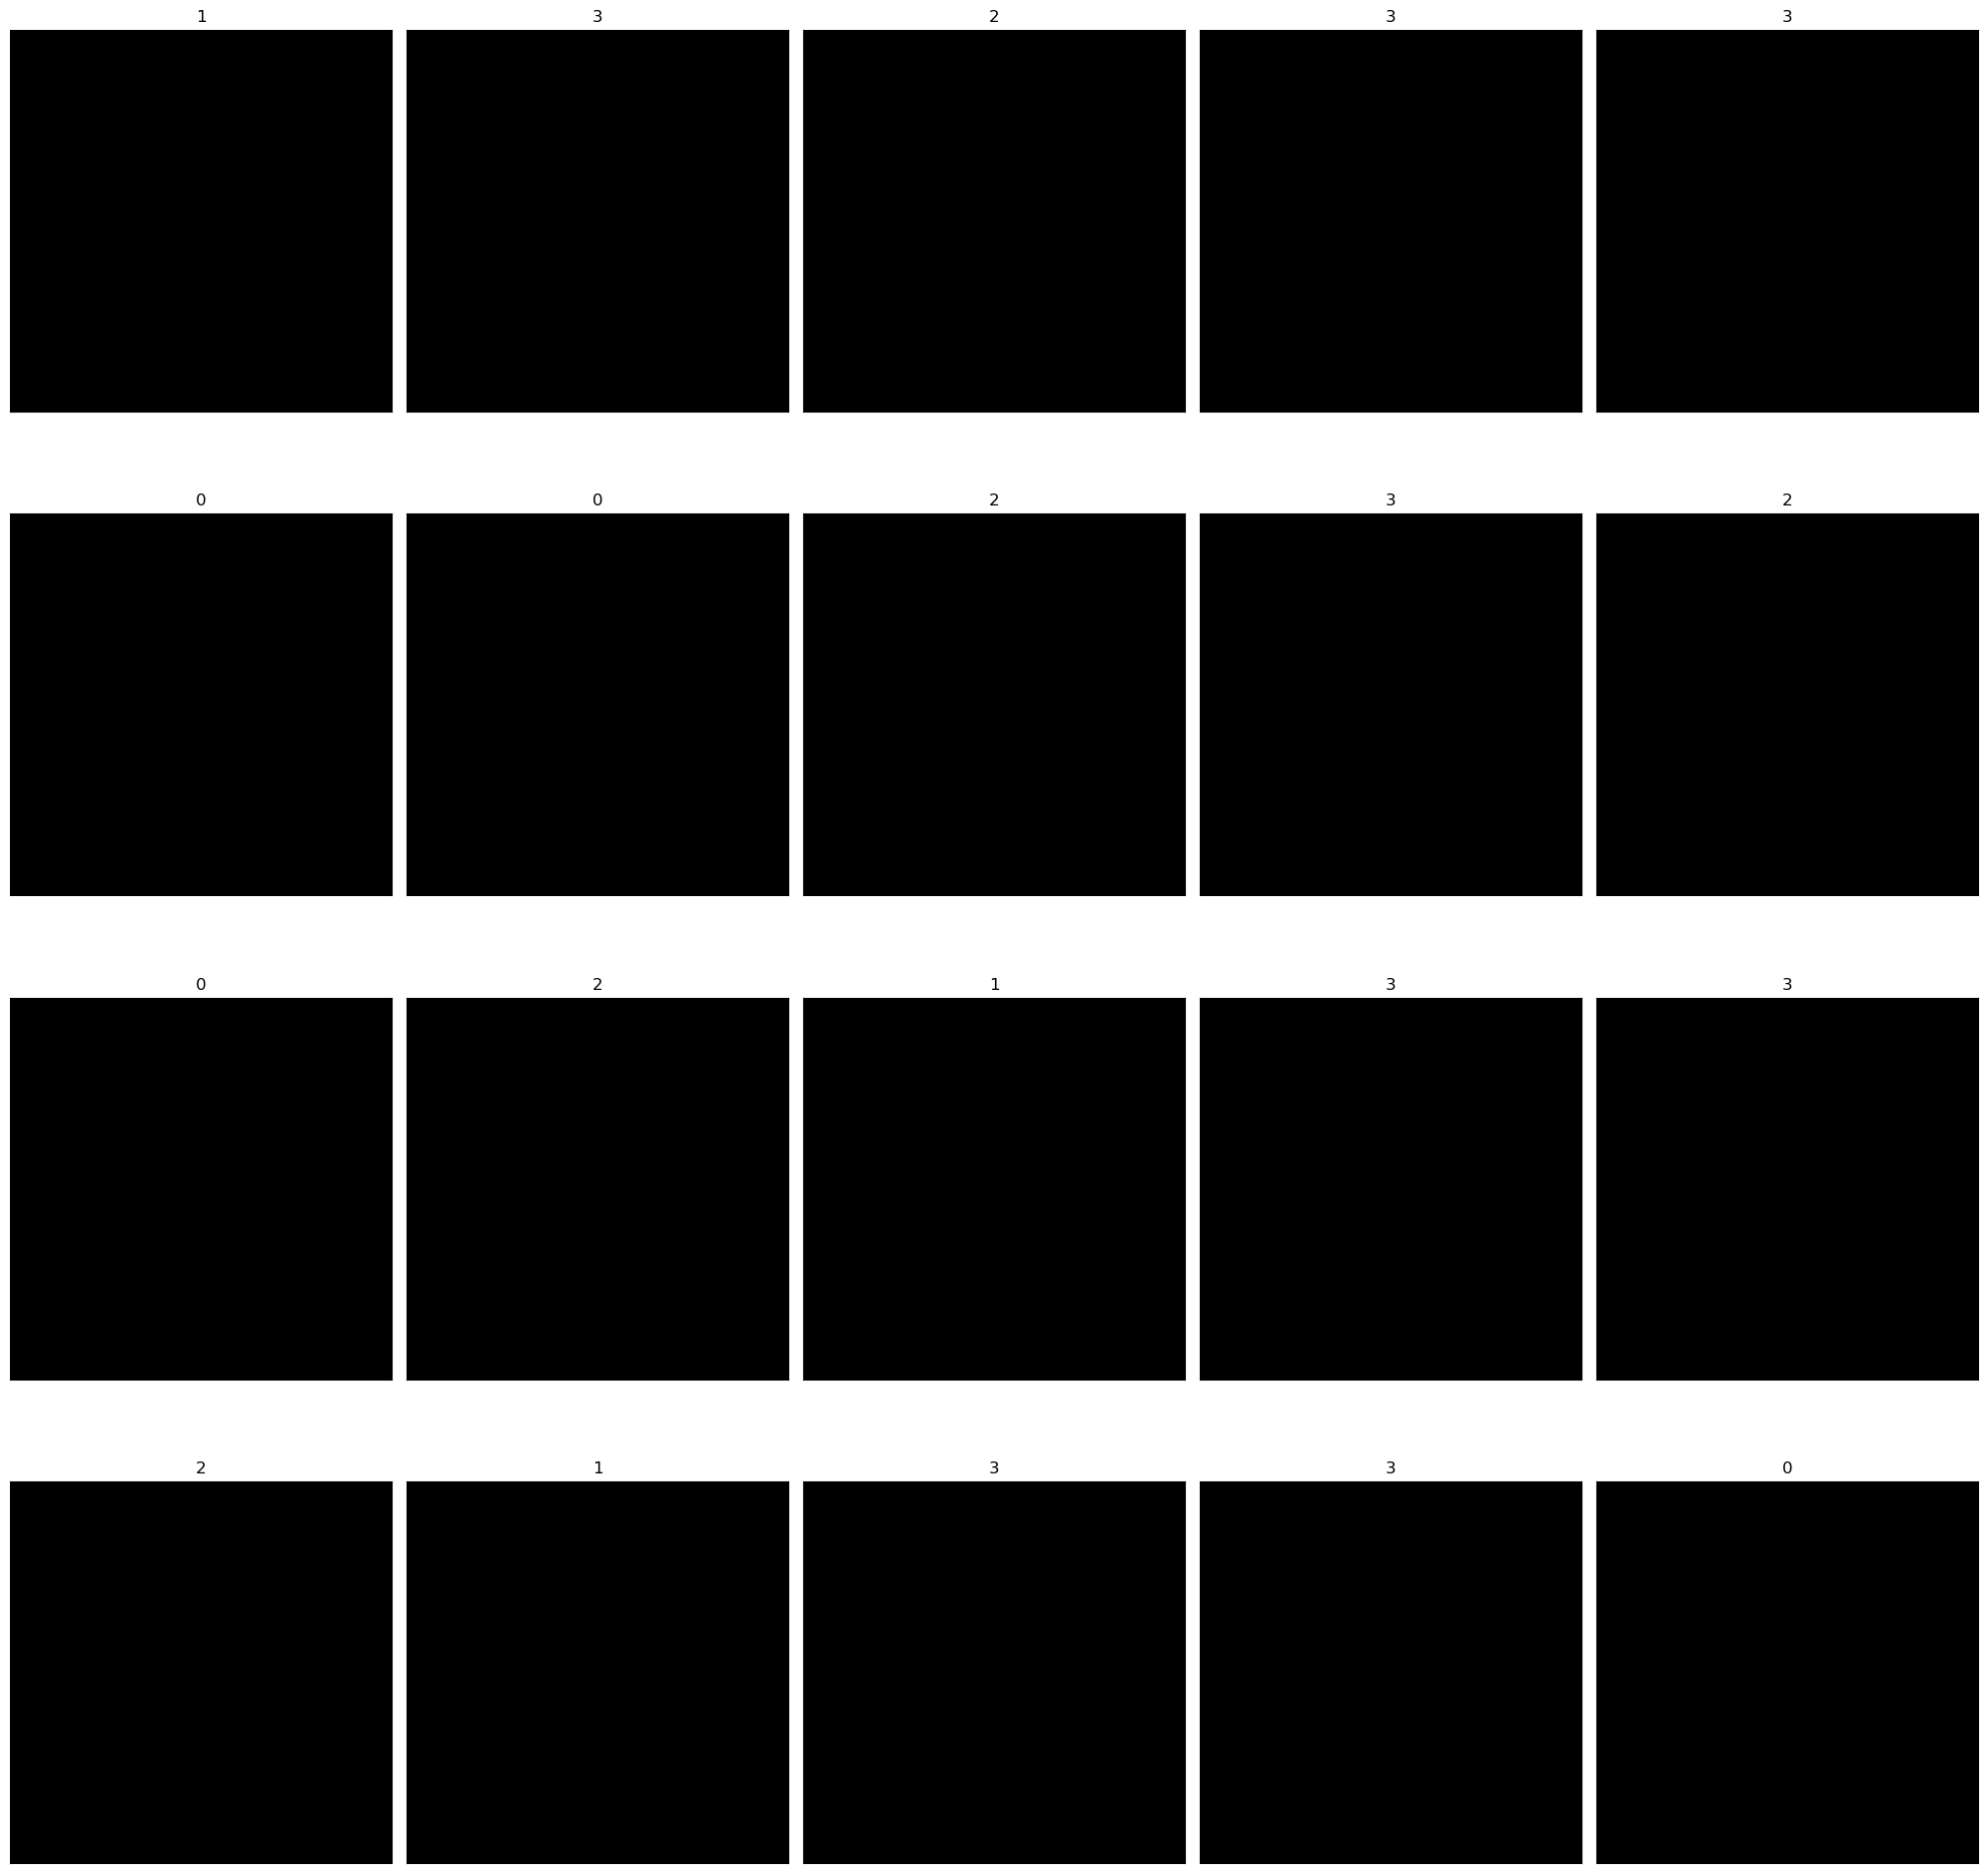

In [135]:
# Check if the generator has produced any batches
try:
    # Get a batch of images and labels
    x_batch, y_batch = next(train_generator)

    # Display the first 20 images from the augmented batch
    plt.figure(figsize=(20, 20))
    num_images_to_display = 20
    for i in range(num_images_to_display):
        plt.subplot(4, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_batch[i])  # Display the image
        plt.title(np.argmax(y_batch[i]))  # Display the class label
    plt.tight_layout()
    plt.show()

except StopIteration:
    print("No images found in the generator.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
# Function to adjust contrast
def augment_with_contrast(image):
    # Adjust contrast; the second parameter is a factor > 1.0 increases contrast
    contrast_factor = 1.5  # Adjust this value as needed
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image



# Define the parameters for the ImageDataGenerator
train_datagen = ImageDataGenerator(
    brightness_range=[0.8,2],
    rescale = 1/255,
    rotation_range=20,
    width_shift_range=0.0,
    height_shift_range=0.0,
    zoom_range=0.0,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Image segmentation 
def display_segmented_images(augmented_images, num_images_to_display=100, threshold_value=0.5):
    plt.figure(figsize=(20, 20))
    
    
# Function to perform threshold segmentation
def threshold_segmentation(image, threshold_value=0.5):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2GRAY)
    
    # Apply a binary threshold
    _, binary_image = cv2.threshold(gray_image, threshold_value * 255, 255, cv2.THRESH_BINARY)
    
    return binary_image



def preprocess_image(image, target_height, target_width):
    # Resize while maintaining aspect ratio
    image = tf.image.resize(image, [224, 224])
    
    # Center crop the image to ensure it fits perfectly
    image = tf.image.central_crop(image, central_fraction=1.0)  # Adjust as needed
    
    return image

val_datagen = ImageDataGenerator()  # No augmentation for validation data

# Define paths to training and validation data
train_image_dir = '/Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Train'  
val_image_dir = '/Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Val' 


# Load and augment training data
train_generator = train_datagen.flow_from_directory(
    train_image_dir,
    target_size=(224,224),  
    batch_size=100,                     
    class_mode='categorical'                        
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    val_image_dir,
    target_size=(224,224),
    batch_size=100,
    class_mode='categorical'                 
)

# Now train_generator and val_generator can be used in model training
